<a href="https://colab.research.google.com/github/mralamdari/CV-Object-Detection-Projects/blob/main/Flowers_Recognition's_optimal_approach(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hello 👋
####This repository will give you a simple approach (but an effective one) to code in PyTorch that can be used recursively for any other problems in Machine Learning/Deep Learning Field.


#####Unfortunately, the Ram crushes in the Colab, so I can't train it with PyTorch; if you have more ram, feel free to run this code, but if you don't have a powerful system to run it, you can run this code in [My Kaggle Notebook](https://www.kaggle.com/code/mralamdari/flowers-recognition-s-optimal-approach-PyTorch), there are more models with trainning results in this notebook and you can easily edit and run it.
#####You can get more details on this project and learn about object recognition on my article on medium; [How to do Object Recognition with PyTorch(Keras) the Easiest way](https://medium.com/@mr.alamdari/imagehow-to-do-object-recognition-with-PyTorch-keras-the-easiest-way-23c7ab9604c7)

# 1.Import Essential Libraris


In [1]:
import os
import cv2
import copy
import time
import tqdm
import torch
import warnings
import matplotlib
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics, preprocessing

In [2]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip \*.zip && rm *.zip

#2. Data
The Dataset in this project contains 4242 images of flowers; the data collection is based on the data Flickr, Google Images, and Yandex images, and it is used to recognize plants from the photo. There are five kinds of flowers: daisy, dandelion, rose, sunflower, and tulip, and each class has about 800 pictures of different sizes but not high resolutions. You can access the dataset here.

In PyTorch, you can readily do DataAugmentation and grow your dataset's size; since Neural Networks need more data to train, it will enhance the model's performance.

### Transformer

In [3]:
path = '/content/flowers'

In [4]:
mean = (0.4124234616756439, 0.3674212694168091, 0.2578217089176178)
std = (0.3268945515155792, 0.29282665252685547, 0.29053378105163574)

In [5]:
transformer = {
    'original': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset1': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                               torchvision.transforms.RandomRotation(5),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset2': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.RandomHorizontalFlip(),
                                               torchvision.transforms.RandomRotation(10),
                                               torchvision.transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.RandomErasing(inplace=True, scale=(0.01,  0.23)),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset3': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                               torchvision.transforms.RandomRotation(15),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
}

### Train/Test/Val Split

In [6]:
#all dataset ==> train&val + test
original = torchvision.datasets.ImageFolder(path, transform=transformer['original'])
train_val, test = model_selection.train_test_split(original, test_size=0.2, random_state=32, shuffle=True)

In [10]:
# train_val  ==> train + val + dataset1 + dataset2 + dataset3
train_val_ds = torch.utils.data.ConcatDataset([train_val,
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset1']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset2']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset3'])])

In [11]:
train, val = model_selection.train_test_split(train_val_ds, test_size=0.1, random_state=32, shuffle=True)

###Notice:
since there isn't enough ram to support all dataset1 + dataset2 + dataset3, I will only use train_val and test set as my train / val datasets.

In [7]:
train = train_val
val = test

### Data Loader

In [8]:
batch_size=32
data_loaders = {
    'train': torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=2, pin_memory=True),
    'val': torch.utils.data.DataLoader(val, batch_size=batch_size, num_workers=2, pin_memory=True),
    'test': torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=2, pin_memory=True)
}

dataset_sizes = {
    'train': len(train),
    'val': len(val),
    'test': len(test)
}

In [9]:
dataset_sizes

{'test': 864, 'train': 3453, 'val': 864}

#### How ImBalance is ourdaset

In [10]:
dic = {}
for cls in original.classes:
  dic[cls] = len(os.listdir(f'{path}/{cls}'))

samplesize = pd.DataFrame(dic, index=[0])
samplesize

,daisy,dandelion,rose,sunflower,tulip
0,764,1052,784,733,984


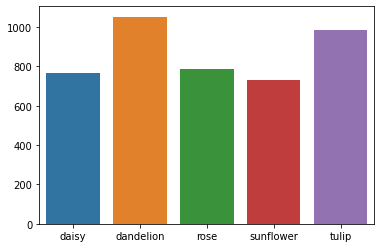

In [15]:
sns.barplot(data=samplesize)

# 3.Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0876) tensor(0.8731)


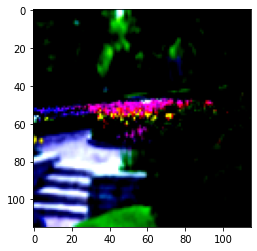

In [ ]:
z, _ = next(iter(data_loaders['test']))
print(z.mean(), z.std())
img_norm = z[0].permute(1, 2, 0).numpy()
plt.imshow(img_norm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.1441) tensor(0.9451)


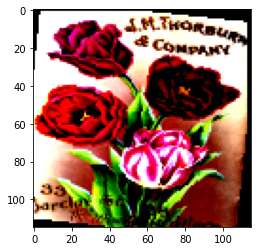

In [ ]:
z, _ = next(iter(data_loaders['val']))
print(z.mean(), z.std())
img_norm = z[0].permute(1, 2, 0).numpy()
plt.imshow(img_norm)

In [ ]:
def plot_imgs(imgs, nrows=5, ncols=5):
  fig, ax = plt.subplots(nrows, ncols, figsize=(nrows*5, ncols*3))
  index = 0
  for row in range(nrows):
    for col in range(ncols):
      img = matplotlib.image.imread(imgs[index][0])
      ax[row][col].imshow(img)
      ax[row][col].axis('off')
      ax[row][col].set_title(imgs[index][1], fontsize=15)
      index += 1

In [ ]:
def rand_imgs(original, img_folder=path, count=25):
  rand_imgs = []
  categories = original.classes
  for cat in categories:
    folder_path = f"{img_folder}/{cat}"
    imgs_list = os.listdir(folder_path)
    selected_imgs = np.random.choice(imgs_list, count//len(categories))
    rand_imgs.extend([(f'{folder_path}/{img_path}', cat) for img_path in selected_imgs])
  np.random.shuffle(rand_imgs)
  return rand_imgs

In [ ]:
my_imgs = rand_imgs(original, path, 15)

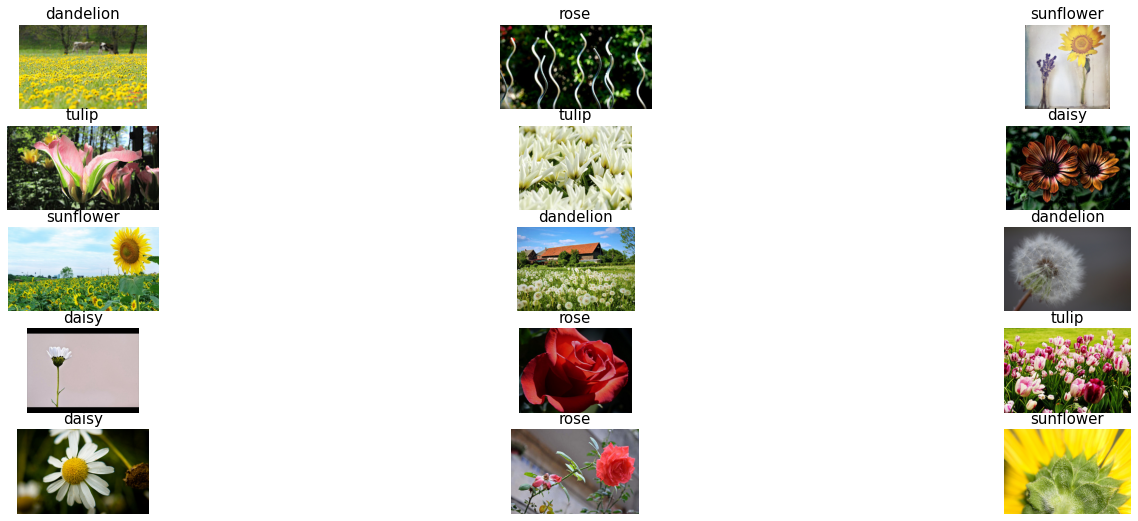

In [ ]:
plot_imgs(my_imgs, 5, 3)

In [ ]:
def plot_batch(data_loader):
  for imgs, labels in data_loader:
    fig, ax = plt.subplots(figsize=(25, 25))
    ax.imshow(torchvision.utils.make_grid(imgs[:60], nrow=10).permute(1, 2, 0))
    ax.set_title('Augmented Images')
    break

In [ ]:
plot_batch(data_loaders['train'])

In [ ]:
plot_batch(data_loaders['val'])

In [ ]:
plot_batch(data_loaders['test'])

# 4.Loss

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds)), preds

In [13]:
path2weights = '/content/models/'
os.makedirs(path2weights, exist_ok=True)

In [14]:
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

In [15]:
def loss_epoch(model, data_loader, criterion, optimizer, sanity_check, phase):
  epoch_loss = 0.0
  epoch_acc = 0.0

  for input, labels in data_loader:
    inputs = input.to(device)
    labels = labels.to(device)
  
    with torch.set_grad_enabled(phase=='train'):
      output = model(inputs)
      loss = criterion(output, labels)
      _, pred = torch.max(output, 1)
#     pred = output.argmax(dim=1, keepdim=True)

    if phase == 'train':
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    epoch_acc += pred.eq(labels.view_as(pred)).sum().item() / len(labels)
    epoch_loss += loss.cpu().detach().numpy() / len(labels)
        
    if sanity_check:
      break

  return epoch_loss, epoch_acc

In [34]:
def train_val(model, params, requires_grad_param=False, trainable_layers=0):
  
  model_name = params['model_name']
  num_epochs = params['epochs']
  optimizer = params['optimizer']
  criterion = params['criterion']
  scheduler = params['scheduler']
  data_loaders = params['data_loaders']
  path2weights = params['path2weights']
  sanity_check = params['sanity_check']
    
  #A dictionary to save Loss's history and accuracy's history
  loss_history = {'train': [], 'val':[]}
  accuracy_history = {'train': [], 'val':[]}
  lr = [get_lr(optimizer)]
    
  #Unfreeze the model, with trainable_layers count
  if requires_grad_param:
      model_params_len = len(list(model.parameters()))
      for i, param in enumerate(model.parameters()):
        if model_params_len - i > trainable_layers:
          param.requires_grad == requires_grad_param
  
  model.to(device) 
  best_accuracy = 0.0
  best_loss = float('inf')
  best_model = copy.deepcopy(model.state_dict())

  for epoch in range(num_epochs):
    
    for phase in ['train', 'val']:
      start = time.time()  
      if phase == 'train':
        model.train()
      else:
        model.eval()

      epoch_loss, epoch_acc = loss_epoch(model, data_loaders[phase], criterion, optimizer, sanity_check, phase)
      loss_history[phase].append(epoch_loss)
      accuracy_history[phase].append(epoch_acc)

      if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model = copy.deepcopy(model.state_dict())
        torch.save(best_model, f'{model_name}_wts.h5')
#         print(f'The best Model has been saved with loss: {best_loss:.3f}!!!')


      if phase == 'val':
        scheduler.step(epoch_loss)
        if lr[-1] != get_lr(optimizer):
  #         print('loading best model weights')
          model.load_state_dict(best_model)

      during = time.time() - start
      print(f'{phase.upper()} ===> Time: {during//60}m {during%60:.2f}s')
    
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {loss_history['train'][-1]:.4f}, Train Accuracy: %{accuracy_history['train'][-1]:.3f}, Val Loss: {loss_history['val'][-1]:.4f}, Val Accuracy: %{accuracy_history['val'][-1]:.4f}")
    print('======'*5)
        
  model.load_state_dict(best_model)        
  return model, loss_history, accuracy_history

In [35]:
def plot_history(hist, loss='True'):
  title = 'loss' if loss else 'accuracy'
  plt.plot(hist[f'train'])
  plt.plot(hist[f'val'])
  plt.title(f'Model {title}')
  plt.ylabel(f'{title}')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

# 5.Models

##### sanity_check is used in the model's train function to determin if we want to train the model by all the dataset or just one batch from a dataset is enough for our training because we only want to check if the model is working correctly or not?
#### sanity_check == True   ====> Use the whole dataset
#### sanity_check == False   ====> Use only one batch of the dataset

In [20]:
sanity_check = False

## VGG16

In [21]:
vgg16 = torchvision.models.vgg16(pretrained=True)

for param in vgg16.parameters():
    param.requires_grad = False

vgg16.classifier[6] = torch.nn.Linear(in_features=vgg16.classifier[6].in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
optimizer_vgg16 = torch.optim.Adam(vgg16.classifier.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler_vgg16 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg16, mode='max', patience=3, verbose=1)
epochs = 10
batch_size = 32
params_vgg16 = {
    'epochs': epochs,
    'model_name': 'vgg16',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer_vgg16,
    'scheduler': scheduler_vgg16,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

## VGG19

In [ ]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)

for param in vgg19_bn.parameters():
    param.requires_grad = False

vgg19_bn.classifier[6] = torch.nn.Linear(in_features=vgg19_bn.classifier[6].in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
optimizer = torch.optim.Adam(vgg19_bn.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True),
epochs = 10
batch_size = 32
params = {
    'epochs': epochs,
    'model_name': 'vgg19_bn',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer,
    'scheduler': scheduler,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

## Inceptionv3

In [ ]:
inceptionv3 = torchvision.models.inception_v3(pretrained=True)

for param in inceptionv3.parameters():
    param.requires_grad = False

inceptionv3.classifier = torch.nn.Linear(in_features=inceptionv3.fc.in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

In [ ]:
optimizer_inceptionv3 = torch.optim.Adam(inceptionv3.fc.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler_inceptionv3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_inceptionv3, mode='max', patience=3, verbose=1)
epochs = 10
batch_size = 32
params = {
    'epochs': epochs,
    'model_name': 'inceptionv3',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer_inceptionv3,
    'scheduler': scheduler_inceptionv3,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

## ResNet50

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

resnet50.classifier = torch.nn.Linear(in_features=resnet50.fc.in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

In [ ]:
optimizer_resnet50 = torch.optim.Adam(resnet50.fc.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler_resnet50 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_resnet50, mode='max', patience=3, verbose=1)
epochs = 10
batch_size = 32
params = {
    'epochs': epochs,
    'model_name': 'resnet50',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer_resnet50,
    'scheduler': scheduler_resnet50,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

## EfficientNet B2

In [ ]:
efficientnetb2 = torchvision.models.efficientnet_b2(pretrained=True)

for param in efficientnetb2.parameters():
    param.requires_grad = False

efficientnetb2.classifier = torch.nn.Linear(in_features=efficientnetb2.classifier[1].in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

In [ ]:
optimizer_efficientnetb2 = torch.optim.Adam(efficientnetb2.classifier.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler_efficientnetb2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_efficientnetb2, mode='max', patience=3, verbose=1)
epochs = 10
batch_size = 32
params = {
    'epochs': epochs,
    'model_name': 'efficientnetb2',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer_efficientnetb2,
    'scheduler': scheduler_efficientnetb2,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

# 6.Training

In [37]:
model, loss_history, accuracy_history = train_val(vgg16, params_vgg16, requires_grad_param=False, trainable_layers=0)

TRAIN ===> Time: 0.0m 18.21s
VAL ===> Time: 0.0m 6.35s
Epoch: 1/10, Train Loss: 1.5605, Train Accuracy: %90.587, Val Loss: 0.3700, Val Accuracy: %22.8125
TRAIN ===> Time: 0.0m 16.63s
VAL ===> Time: 0.0m 6.47s
Epoch: 2/10, Train Loss: 1.4983, Train Accuracy: %91.615, Val Loss: 0.3600, Val Accuracy: %22.8750
TRAIN ===> Time: 0.0m 16.30s
VAL ===> Time: 0.0m 6.49s
Epoch: 3/10, Train Loss: 1.4350, Train Accuracy: %92.425, Val Loss: 0.3478, Val Accuracy: %23.0625
TRAIN ===> Time: 0.0m 16.11s
VAL ===> Time: 0.0m 6.43s
Epoch: 4/10, Train Loss: 1.3819, Train Accuracy: %92.650, Val Loss: 0.3430, Val Accuracy: %23.0000
TRAIN ===> Time: 0.0m 16.28s
Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
VAL ===> Time: 0.0m 6.25s
Epoch: 5/10, Train Loss: 1.3325, Train Accuracy: %93.712, Val Loss: 0.3364, Val Accuracy: %23.1875
TRAIN ===> Time: 0.0m 16.38s
VAL ===> Time: 0.0m 6.52s
Epoch: 6/10, Train Loss: 1.3229, Train Accuracy: %93.459, Val Loss: 0.3345, Val Accuracy: %23.1562
TRAIN ===> Tim

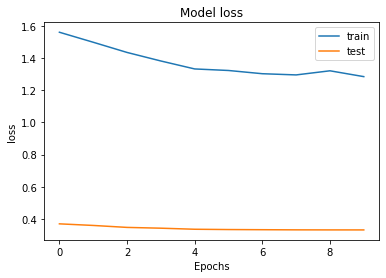

In [38]:
plot_history(loss_history, loss='True')

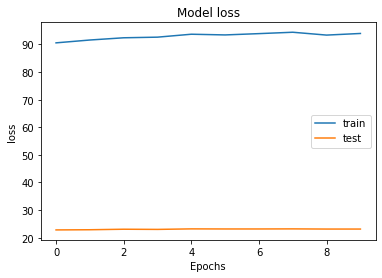

In [41]:
plot_history(accuracy_history, loss='False')